In [100]:
import pandas as pd
import spacy
from pathlib import Path
from scipy.stats import zscore
import matplotlib.pyplot as plt
import os
from textstat import flesch_reading_ease
import numpy as np

In [39]:
# loading language model from spacy library which is lightweight, fast, and for english web sources

nlp = spacy.load("en_core_web_sm")

In [40]:
# all possible keywords relating to data sharing/leaks

keywords = [
    "share", "third party", "sell", "disclose", "data", "personal information",
    "analytics", "advertising", "collect", "tracking", "cookies", "metadata",
    "behavioral data", "location data", "usage data", "store", "process",
    "transmit", "profiling", "identifier", "IP address", "device ID",
    "user data", "biometric data", "sensitive data", "data broker",
    "data retention", "data processing", "data usage", "data sharing",
    "information collected", "user information", "data subject", "data access",
    "data transfer", "third-party services", "aggregated data",
    "personalized advertising", "marketing", "targeting", "demographic data",
    "data sale", "data storage", "data analytics", "privacy policy",
    "consent", "data collection", "data controller", "data processor",
    "information sharing", "automated decision-making", "web beacons", 
    "pixel tags", "cross-site tracking", "fingerprinting",
    "session data", "telemetry", "user profiling", "surveillance",
    "real-time bidding", "geo-location", "mobile identifiers", "clickstream data",
    "third-party cookies", "re-identification", "data fusion", "data enrichment",
    "customer data platform", "CDP", "CRM data", "purchase history",
    "login credentials", "social graph", "data monetization", "data mining",
    "data scraping", "cloud storage", "API access", "bulk data export",
    "data leakage", "privacy violation", "confidential data", "PII",
    "anonymized data", "de-identified data", "hashed data", "opt-out",
    "terms of service", "behavioral tracking", "data warehouse", "big data",
    "digital footprint", "consent management", "third-party integrations",
    "user tracking", "usage metrics", "data-driven insights", "affiliates",
    "data correlation", "data visualization", "data warehouse", "real-time analytics"
]

In [41]:
# using the key words, keeping track of how many sentences have these key words and how many total sentences there are for one txt file

def analyze_text(text, keywords):
    doc = nlp(text)
    sentences = list(doc.sents)
    total = len(sentences)
    data_related = [s for s in sentences if any(k in s.text.lower() for k in keywords)]
    return total, len(data_related)

In [42]:
# processing data sentences and total sentences across all txt files onto the dataframe

def process_app_data(csv_path, txt_dir):
    df = pd.read_csv(csv_path)
    df["Total Sentences"] = 0
    df["Data Sentences"] = 0
    df["Data Sentence Proportion"] = 0.0

    for i, row in df.iterrows():
        app_name = row['Name']
        txt_path = Path(txt_dir) / f"{app_name}.txt"

        if txt_path.exists():
            text = txt_path.read_text(encoding='utf-8')
            total, data_count = analyze_text(text, keywords)
            df.at[i, "Total Sentences"] = total
            df.at[i, "Data Sentences"] = data_count
            df.at[i, "Data Sentence Proportion"] = round(data_count / total, 3) if total > 0 else 0.0
        else:
            print(f"Missing: {txt_path}")

    return df

In [43]:
# constants for all the directories (csv files & txt folders)

safe_csv = "compiled_data/safe_apps.csv"
unsafe_csv = "compiled_data/unsafe_apps.csv"
test_csv = "compiled_data/test_apps.csv"

safe_txt_dir = "raw_data/safe"
unsafe_txt_dir = "raw_data/unsafe"
test_txt_dir = "raw_data/test"

In [44]:
# processed data for safe apps

df_safe = process_app_data(safe_csv, safe_txt_dir)
print("Safe Apps Preview:")
print(df_safe.head())

Safe Apps Preview:
        Name  Data Sentences  Total Sentences  Data Sentence Proportion  \
0  Pinterest               1                3                     0.333   
1   Mastodon              22               64                     0.344   
2   LinkedIn             157              277                     0.567   
3       Vero             306              451                     0.678   
4       MeWe             118              180                     0.656   

   Readability Score  Long Sentences  Vague Sentences  \
0                NaN             NaN              NaN   
1                NaN             NaN              NaN   
2                NaN             NaN              NaN   
3                NaN             NaN              NaN   
4                NaN             NaN              NaN   

   Long or Vague Sentences  Long or Vague Sentence Proportion  
0                      NaN                                NaN  
1                      NaN                                N

In [45]:
# processed data for unsafe apps

df_unsafe = process_app_data(unsafe_csv, unsafe_txt_dir)
print("Unsafe Apps Preview:")
print(df_unsafe.head())

Missing: raw_data\unsafe\Character.AI.txt
Unsafe Apps Preview:
           Name  Data Sentences  Total Sentences  Data Sentence Proportion  \
0          Wizz             108              178                     0.607   
1        Teabot              14               79                     0.177   
2      VajraSpy              25               45                     0.556   
3  eXotic Visit              32               61                     0.525   
4        TikTok             118              183                     0.645   

   Readability Score  Long Sentences  Vague Sentences  \
0                NaN             NaN              NaN   
1                NaN             NaN              NaN   
2                NaN             NaN              NaN   
3                NaN             NaN              NaN   
4                NaN             NaN              NaN   

   Long or Vague Sentences  Long or Vague Sentence Proportion  
0                      NaN                                NaN

In [46]:
# processed data for testing apps

df_test = process_app_data(test_csv, test_txt_dir)
print("Test Apps Preview:")
print(df_test.head())

Test Apps Preview:
                             Name  Data Sentences  Total Sentences  \
0   Flo Period Tracker & Calendar             176              275   
1     Clue Period & Cycle Tracker             273              422   
2  Ovia Fertility & Cycle Tracker              97              121   
3  Glow Period, Fertility Tracker             208              313   
4                  Natural Cycles             206              305   

   Data Sentence Proportion  Readability Score  Long Sentences  \
0                     0.640                NaN             NaN   
1                     0.647                NaN             NaN   
2                     0.802                NaN             NaN   
3                     0.665                NaN             NaN   
4                     0.675                NaN             NaN   

   Vague Sentences  Long or Vague Sentences  Long or Vague Sentence Proportion  
0              NaN                      NaN                                NaN  
1

In [47]:
# removing outliers using 2 standard deviation threshold (95% data)

def remove_outliers_zscore(dataframe, column, threshold=2):
    z_scores = zscore(dataframe[column])
    return dataframe[abs(z_scores) <= threshold]

In [48]:
# cleaning up any outliers in all the data for data sentences and total sentences

df_safe_clean1 = remove_outliers_zscore(df_safe, "Data Sentences")
df_safe_clean = remove_outliers_zscore(df_safe, "Total Sentences")

df_unsafe_clean1 = remove_outliers_zscore(df_unsafe, "Data Sentences")
df_unsafe_clean = remove_outliers_zscore(df_unsafe, "Total Sentences")

df_test_clean1 = remove_outliers_zscore(df_test, "Data Sentences")
df_test_clean = remove_outliers_zscore(df_test, "Total Sentences")

In [49]:
# provides summary stats for a given dataframe based on AVERAGES

def average_summarize_df(df, label):
    summary = {
        "Label": label,
        "Number of Samples": len(df),
        "Average Data Sentences": df["Data Sentences"].mean(),
        "Average Total Sentences": df["Total Sentences"].mean(),
        "Average Data Sentence Proportion": df["Data Sentence Proportion"].mean()
    }
    return summary

In [50]:
# application of average summaries

average_summary_df = pd.DataFrame([
    average_summarize_df(df_safe_clean, "Safe"),
    average_summarize_df(df_unsafe_clean, "Unsafe"),
    average_summarize_df(df_test_clean, "Test")
])

In [51]:
average_summary_df

,Label,Number of Samples,Average Data Sentences,Average Total Sentences,Average Data Sentence Proportion
0,Safe,44,76.477273,137.363636,0.526795
1,Unsafe,41,75.902439,138.756098,0.531122
2,Test,38,87.184211,134.131579,0.642921


In [52]:
# provides summary stats for a given dataframe based on MEDIANS

def median_summarize_df(df, label):
    summary = {
        "Label": label,
        "Number of Samples": len(df),
        "Median Data Sentences": df["Data Sentences"].median(),
        "Median Total Sentences": df["Total Sentences"].median(),
        "Median Data Sentence Proportion": df["Data Sentence Proportion"].median()
    }
    return summary

In [53]:
# application of MEDIAN summaries

median_summary_df = pd.DataFrame([
    median_summarize_df(df_safe_clean, "Safe"),
    median_summarize_df(df_unsafe_clean, "Unsafe"),
    median_summarize_df(df_test_clean, "Test")
])

In [54]:
median_summary_df

,Label,Number of Samples,Median Data Sentences,Median Total Sentences,Median Data Sentence Proportion
0,Safe,44,49.5,98.0,0.5395
1,Unsafe,41,70.0,141.0,0.5910
2,Test,38,81.0,114.5,0.6400


In [117]:
# Function to plot relative frequency histograms for all three datasets

def plot_relative_frequency_histogram(column_name, y_max, bins=10):
    # calculating the min and max x values (y goes from 0 to second parameter)
    min_value = min(df_safe_clean[column_name].min(), df_unsafe_clean[column_name].min(), df_test_clean[column_name].min())
    max_value = max(df_safe_clean[column_name].max(), df_unsafe_clean[column_name].max(), df_test_clean[column_name].max())

    total_data_points = len(df_safe_clean[column_name]) + len(df_unsafe_clean[column_name]) + len(df_test_clean[column_name])

    # plotting one histogram
    def plot_histogram(data, dataset_name):
        counts, bin_edges = np.histogram(data, bins=bins, range=(min_value, max_value))
        relative_frequency = counts / total_data_points
        
        plt.bar(bin_edges[:-1], relative_frequency, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel(column_name)
        plt.ylabel("Relative Frequency")
        plt.title(f"Histogram of {column_name} ({dataset_name})")
        plt.xlim(min_value, max_value)
        plt.ylim(0, y_max * 1.1)
        plt.show()

    # applying single histogram plotting for all three data groups
    plot_histogram(df_safe_clean[column_name], "Safe")
    plot_histogram(df_unsafe_clean[column_name], "Unsafe")
    plot_histogram(df_test_clean[column_name], "Test")

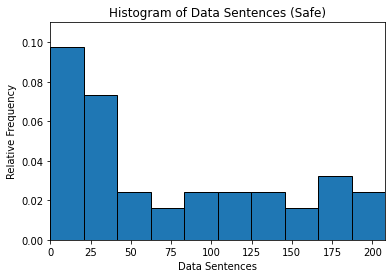

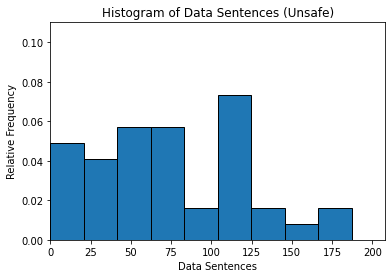

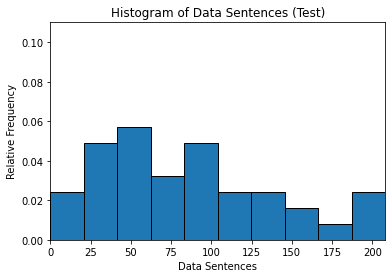

In [118]:
plot_relative_frequency_histogram("Data Sentences", 0.1)

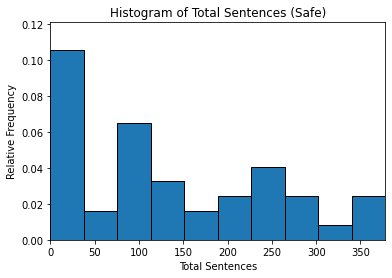

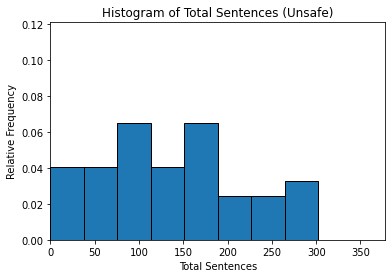

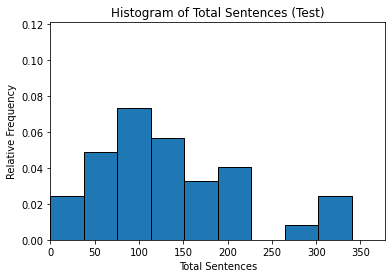

In [111]:
plot_relative_frequency_histogram("Total Sentences", 0.11)

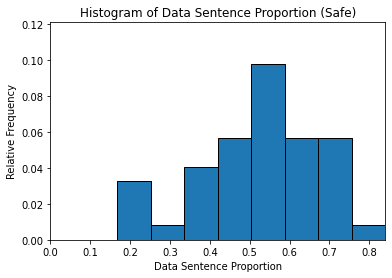

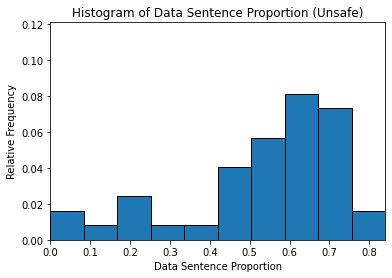

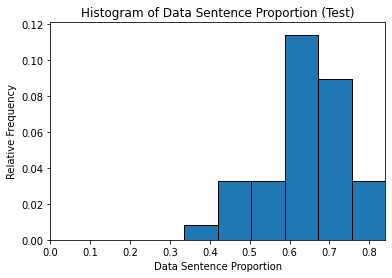

In [112]:
plot_relative_frequency_histogram("Data Sentence Proportion", 0.11)

In [58]:
# function to compute readability score for a given text file

def compute_readability(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        score = flesch_reading_ease(text)
        return score
    except:
        return None

In [59]:
# application of readability score function

for df, group in [(df_safe_clean, "safe"), (df_unsafe_clean, "unsafe"), (df_test_clean, "test")]:
    scores = []
    for name in df["Name"]:
        file_path = os.path.join("raw_data", group, f"{name}.txt")
        scores.append(compute_readability(file_path))
    df.loc[:, "Readability Score"] = scores

C:\Users\Chick\AppData\Local\Temp/ipykernel_9776/1081741312.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41.4, 37.94, 25.19, 40.89, 28.77, 39.47, 15.54, 42.82, 20.86, 34.56, 15.78, 43.02, 32.94, 36.83, 36.22, 28.67, 28.98, 40.38, 54.42, 36.18, 24.95, 35.61, 29.59, 26.34, 45.35, 18.99, 29.89, 36.93, 27.29, 30.4, 13.35, 11.72, 30.6, 34.46, 27.15, 38.15, 40.35, 23.66, 30.7, 22.48, None]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, "Readability Score"] = scores


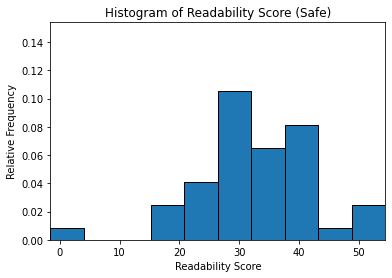

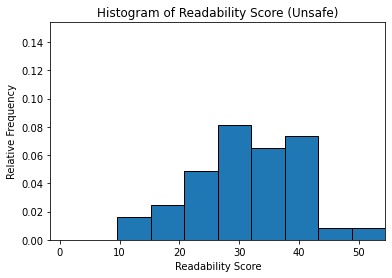

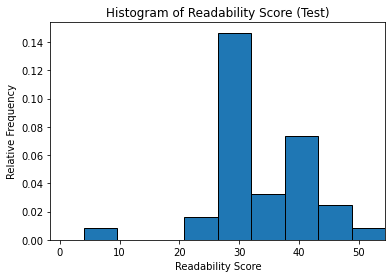

In [114]:
plot_relative_frequency_histogram("Readability Score", 0.14)

In [61]:
# summary results with readability scores

def summarize_readability(df, label):
    summary = {
        "Label": label,
        "Number of Samples": len(df),
        "Average Readability Score": df["Readability Score"].mean(),
        "Median Readability Score": df["Readability Score"].median()
    }
    return summary

In [62]:
# application of readability score summaries

readability_summarized_df = pd.DataFrame([
    summarize_readability(df_safe_clean, "Safe"),
    summarize_readability(df_unsafe_clean, "Unsafe"),
    summarize_readability(df_test_clean, "Test")
])

In [63]:
readability_summarized_df

,Label,Number of Samples,Average Readability Score,Median Readability Score
0,Safe,44,32.653182,32.19
1,Unsafe,41,31.470500,30.65
2,Test,38,33.584737,30.40


In [64]:
# vague terms to search for

vague_terms = [
    "may", "might", "could", "possibly", "as needed", "as appropriate", "from time to time", 
    "typically", "generally", "commonly", "we reserve the right", "at our discretion"
]

In [65]:
# calculating the number of long (>25 words), or vague (with the vague terms) sentences & proportions in a txt file

def compute_complexity_vagueness(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
        doc = nlp(text)
        sentences = list(doc.sents)
        total_sentences = len(sentences)

        long_sentences = sum(1 for sent in sentences if len(sent.text.split()) > 25)
        vague_sentences = sum(1 for sent in sentences if any(term in sent.text.lower() for term in vague_terms))

        long_or_vague_sentences = sum(
            1 for sent in sentences 
            if len(sent.text.split()) > 25 or any(term in sent.text.lower() for term in vague_terms)
        )

        proportion = round(long_or_vague_sentences / total_sentences, 3) if total_sentences > 0 else 0.0

        return long_sentences, vague_sentences, long_or_vague_sentences, total_sentences, proportion
    except:
        return 0, 0, 0, 0, 0.0

In [66]:
# application for all txt files

for df, group in [(df_safe_clean, "safe"), (df_unsafe_clean, "unsafe"), (df_test_clean, "test")]:
    long_counts = []
    vague_counts = []
    long_or_vague_counts = []
    proportions = []

    for name in df["Name"]:
        file_path = os.path.join("raw_data", group, f"{name}.txt")
        long, vague, long_or_vague, total, prop = compute_complexity_vagueness(file_path)
        long_counts.append(long)
        vague_counts.append(vague)
        long_or_vague_counts.append(long_or_vague)
        proportions.append(prop)

    df["Long Sentences"] = long_counts
    df["Vague Sentences"] = vague_counts
    df["Long or Vague Sentences"] = long_or_vague_counts
    df["Long or Vague Sentence Proportion"] = proportions

C:\Users\Chick\AppData\Local\Temp/ipykernel_9776/2432963037.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Long Sentences"] = long_counts
C:\Users\Chick\AppData\Local\Temp/ipykernel_9776/2432963037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Vague Sentences"] = vague_counts
C:\Users\Chick\AppData\Local\Temp/ipykernel_9776/2432963037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [73]:
# summarizing the vague/long sentence summaries

def summarize_vagueness(df, label):
    summary = {
        "Label": label,
        "Number of Samples": len(df),
        "Average Long or Vague Sentences": df["Long or Vague Sentences"].mean(),
        "Average Long or Vague Sentence Proportion": df["Long or Vague Sentence Proportion"].mean()
    }
    return summary

In [74]:
vagueness_summarized_df = pd.DataFrame([
    summarize_vagueness(df_safe_clean, "Safe"),
    summarize_vagueness(df_unsafe_clean, "Unsafe"),
    summarize_vagueness(df_test_clean, "Test")
])

In [75]:
vagueness_summarized_df

,Label,Number of Samples,Average Long or Vague Sentences,Average Long or Vague Sentence Proportion
0,Safe,44,58.500000,0.390114
1,Unsafe,41,63.780488,0.447829
2,Test,38,64.447368,0.458868


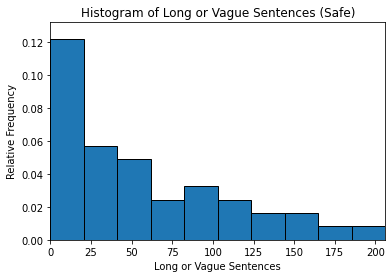

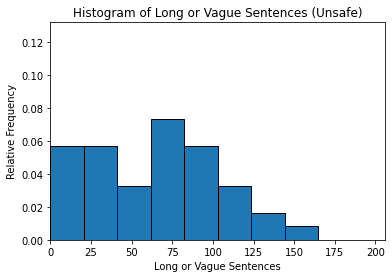

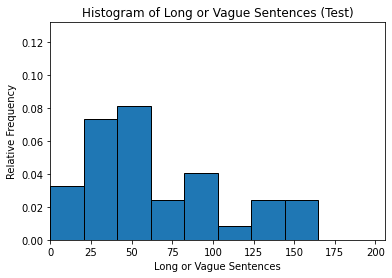

In [121]:
plot_relative_frequency_histogram("Long or Vague Sentences", 0.12)

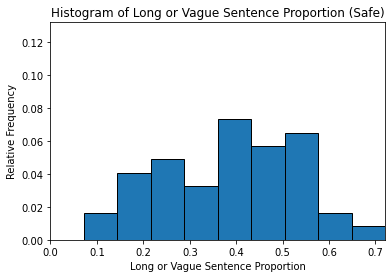

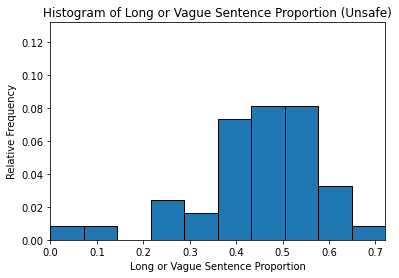

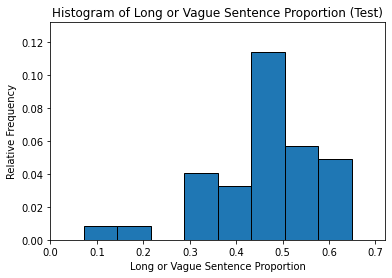

In [123]:
plot_relative_frequency_histogram("Long or Vague Sentence Proportion", 0.12)